para este primeiro modelo, serão removidos os dados com alto ruido através da remoção da seção da envergadura completa

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [257]:
# --- Data Loading ---
input_file = 'Smoothed_CpData_LinearRegion_RemovedLines.csv'
data = pd.read_csv(input_file, sep=';')
print("Successfully loaded data from", input_file)

# Divide the data into features (X) and target (Y):
X = data.iloc[:, 0:2]
Y = data.iloc[:, 2:]

Successfully loaded data from Smoothed_CpData_LinearRegion_RemovedLines.csv


In [258]:
def train_test_split(X, Y, test_samples):
    # Defines the test split condition based on the test_samples:
    test_split = X['Alpha (deg)'].isin(test_samples)

    # Splits the data:
    X_test = X[test_split].copy()
    X_train = X[~test_split].copy()
    Y_test = Y[test_split].copy()
    Y_train = Y[~test_split].copy()

    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, [4, 8])

In [259]:
def data_normalization(X_train, X_test, Y_train, Y_test, normalization_method):
    # Normalize the training and test data using Min-Max scaler::
    if normalization_method == 'min-max':
        # Fit min-max scaler on training data:
        X_normalization = MinMaxScaler().fit(X_train)
        Y_normalization = MinMaxScaler().fit(Y_train)

        # Normalize the training and test data with the same scaler:
        X_train_norm = np.array(X_normalization.transform(X_train))
        X_test_norm = np.array(X_normalization.transform(X_test))
        Y_train_norm = np.array(Y_normalization.transform(Y_train))
        Y_test_norm = np.array(Y_normalization.transform(Y_test))

    # Normalize the training and test data using Standard scaler:
    elif normalization_method == 'standard':
        # Fit standard scaler on training data:
        X_normalization = StandardScaler().fit(X_train)
        Y_normalization = StandardScaler().fit(Y_train)

        # Normalize the training and test data with the same scaler:
        X_train_norm = np.array(X_normalization.transform(X_train))
        X_test_norm = np.array(X_normalization.transform(X_test))
        Y_train_norm = np.array(Y_normalization.transform(Y_train))
        Y_test_norm = np.array(Y_normalization.transform(Y_test))

    return X_train_norm, X_test_norm, Y_train_norm, Y_test_norm, X_normalization, Y_normalization

X_train_norm, X_test_norm, Y_train_norm, Y_test_norm, X_normalization, Y_normalization = data_normalization(X_train, X_test, Y_train, Y_test, 'min-max')

In [260]:
# testar adicionar dropout, regularização e batch normalization na arquitetura:
def create_model(first_layer_neurons, second_layer_neurons, first_layer_function, second_layer_function, optimizer):
    model = Sequential([
            Input(shape=(2,)),
            Dense(first_layer_neurons, activation=first_layer_function, kernel_regularizer=l2(0.001)),
            Dropout(0.2),
            Dense(second_layer_neurons, activation=second_layer_function, kernel_regularizer=l2(0.001)),
            Dense(31, activation='linear')])

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

#model = create_model(64, 32, 'relu', 'relu', 'adam')
#print("Model successfully created.")

In [261]:
model_wrapper = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    # --- Parâmetros da Arquitetura (passados para create_model) ---
    'model__first_layer_neurons': [2, 4, 8, 16, 32, 64, 128],
    'model__second_layer_neurons': [2, 4, 8, 16, 32, 64, 128],
    'model__first_layer_function': ['relu', 'tanh', 'elu'],
    'model__second_layer_function': ['relu', 'tanh', 'elu'],

    # --- Parâmetros de Compilação (passados para create_model) ---
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],

    # --- Parâmetros de Treinamento (passados para .fit()) ---
    'batch_size': [16, 32],                              # Testar 2 tamanhos de lote
    'epochs': [200]}

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 30,
    restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 30,
    min_lr = 1e-6)

# 4. INSTANCIAR O GRIDSEARCHCV
# cv=3 significa validação cruzada de 3 folds (treina em 2/3 dos dados, valida em 1/3, e repete 3x)
# n_jobs=-1 usa todos os núcleos de CPU disponíveis para acelerar a busca
"""
grid = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    scoring='neg_mean_squared_error' # Métrica para avaliar os modelos
)
"""

grid = RandomizedSearchCV(
    estimator=model_wrapper,
    param_distributions=param_grid, # Note que o nome do parâmetro mudou
    n_iter=75,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

print("Iniciando Grid Search... Isso pode demorar bastante.")
grid_result = grid.fit(
    X_train_norm,
    Y_train_norm,
    validation_split=0.25,
    callbacks=[early_stopping, reduce_lr]
)
print("Grid Search concluído.")

print(f"Melhor pontuação (neg_mean_squared_error): {grid_result.best_score_:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(grid_result.best_params_)

model = grid_result.best_estimator_

Iniciando Grid Search... Isso pode demorar bastante.


c:\Users\caiod\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Grid Search concluído.
Melhor pontuação (neg_mean_squared_error): -0.0542
Melhores hiperparâmetros encontrados:
{'model__second_layer_neurons': 32, 'model__second_layer_function': 'elu', 'model__optimizer': 'adam', 'model__first_layer_neurons': 4, 'model__first_layer_function': 'tanh', 'epochs': 200, 'batch_size': 16}


In [ ]:
history = model.fit(
    X_train_norm, Y_train_norm,
    validation_split=0.25,
    epochs=200,
    batch_size=5,
    verbose=1,
    callbacks=[early_stopping, reduce_lr])

In [ ]:
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.suptitle('Training and Validation Loss')
    plt.axis([0, max(epochs), 0, 0.4])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.grid(True)
    plt.legend()
    plt.show()
    return

plot_training_history(history)

AttributeError: 'RandomizedSearchCV' object has no attribute 'history'

MAE  (Erro Absoluto Médio): 0.1475
MSE  (Erro Quadrático Médio): 0.0327
RMSE (Raiz do Erro Quadrático Médio): 0.1809
R²   (Coeficiente de Determinação): 0.3960


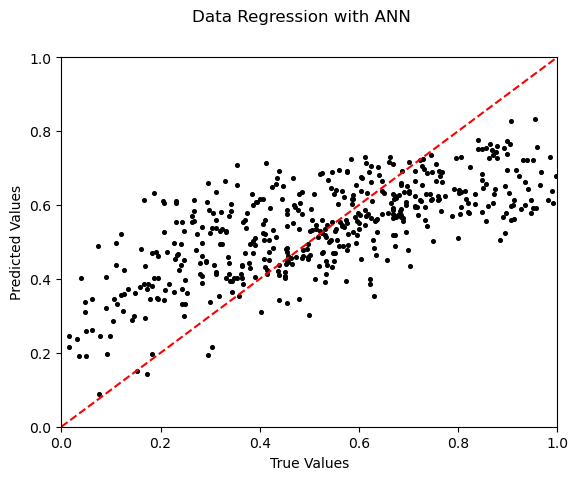

In [263]:
def plot_testing_metrics(model):
    Y_pred = model.predict(X_test_norm)

    print(f"MAE  (Erro Absoluto Médio): {mean_absolute_error(Y_test_norm, Y_pred):.4f}")
    print(f"MSE  (Erro Quadrático Médio): {mean_squared_error(Y_test_norm, Y_pred):.4f}")
    print(f"RMSE (Raiz do Erro Quadrático Médio): {np.sqrt(mean_squared_error(Y_test_norm, Y_pred)):.4f}")
    print(f"R²   (Coeficiente de Determinação): {r2_score(Y_test_norm, Y_pred):.4f}")

    plt.scatter(Y_test_norm, Y_pred, color='k', s=7)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.suptitle("Data Regression with ANN")
    plt.axis([0, 1, 0, 1])
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()

    #x = [0.92, 0.82, 0.73, 0.63, 0.54, 0.46, 0.38, 0.3, 0.24, 0.18, 0.12, 0.08, 0.04, 0.02, 0.01, 0, 0.01, 0.02, 0.04, 0.08,
    #0.12, 0.18, 0.24, 0.3, 0.38, 0.46, 0.54, 0.63, 0.73, 0.82, 0.92]
    #y_test = Y_normalization.inverse_transform(Y_test_norm)
    #y_pred = Y_normalization.inverse_transform(Y_pred)
    #plt.plot(x, y_test[n])
    #plt.plot(x, y_pred[n])
    #plt.show()

    return

plot_testing_metrics(model)